20cm normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*0.169^2))
50cm normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*0.344^2))
1m normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*0.410^2))
2m normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*0.981^2))
5m normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*1.595^2))
10m normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*2.544^2))
15m normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*3.813^2))


/var/folders/_y/dsj8j9554_q1y40shzytdkxr0000gn/T/ipykernel_51868/329768617.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_data, y_data, p0=p0)


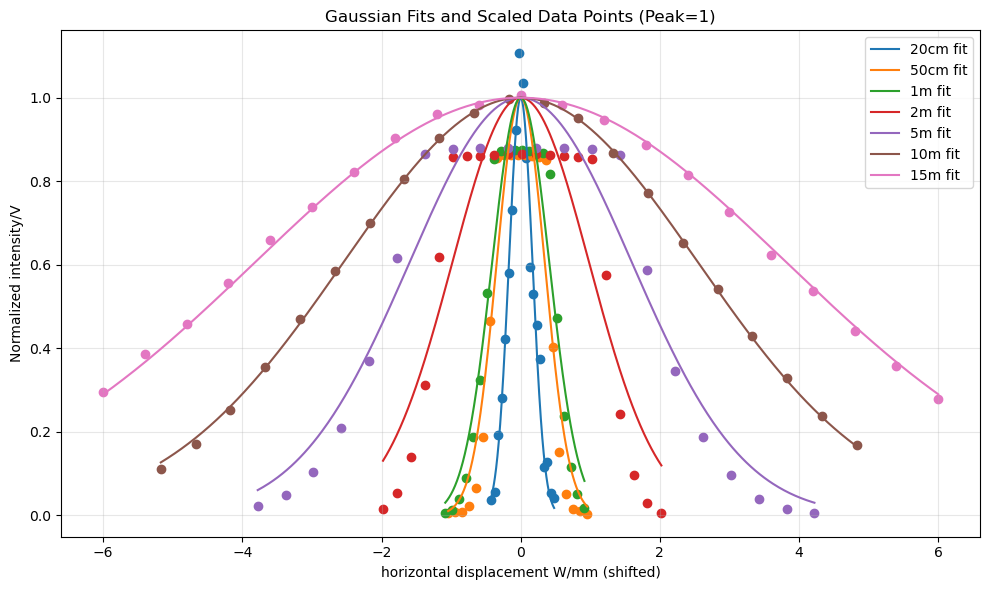

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Gaussian function ---
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

# --- Load data ---
csv_file = "PLLdata.csv"
df = pd.read_csv(csv_file)

# --- Plot setup ---
plt.figure(figsize=(10,6))

# --- Loop through each group in CSV order ---
for group in df["group"].unique():  # preserves CSV order
    data = df[df["group"] == group]
    x_data = data["x"].values
    y_data = data["y"].values

    # Fit Gaussian to original data
    p0 = [np.max(y_data), np.mean(x_data), np.std(x_data)]
    popt, _ = curve_fit(gaussian, x_data, y_data, p0=p0)
    A_fit, mu_fit, sigma_fit = popt

    # Shift x so Gaussian peak is at 0
    x_shifted = x_data - mu_fit

    # Scale original data points so Gaussian peak = 1
    scale_factor = 1 / A_fit
    y_scaled = y_data * scale_factor

    # Generate smooth Gaussian curve normalized to peak = 1
    x_fit = np.linspace(min(x_shifted), max(x_shifted), 500)
    y_fit = gaussian(x_fit, 1, 0, sigma_fit)  # peak at 1

    # Plot scaled data points and Gaussian fit
    plt.scatter(x_shifted, y_scaled)
    plt.plot(x_fit, y_fit, label=f"{group} fit")

    # Print normalized Gaussian equation
    print(f"{group} normalized Gaussian fit: y = 1 * exp(-((x)^2)/(2*{sigma_fit:.3f}^2))")

# --- Final plot formatting ---
plt.xlabel("horizontal displacement W/mm (shifted)")
plt.ylabel("Normalized intensity/V")
plt.title("Gaussian Fits and Scaled Data Points (Peak=1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/_7/dmdtzvfj6kxf9bjk35d2kl340000gn/T/ipykernel_34948/1882731296.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x_data, y_data, p0=p0)


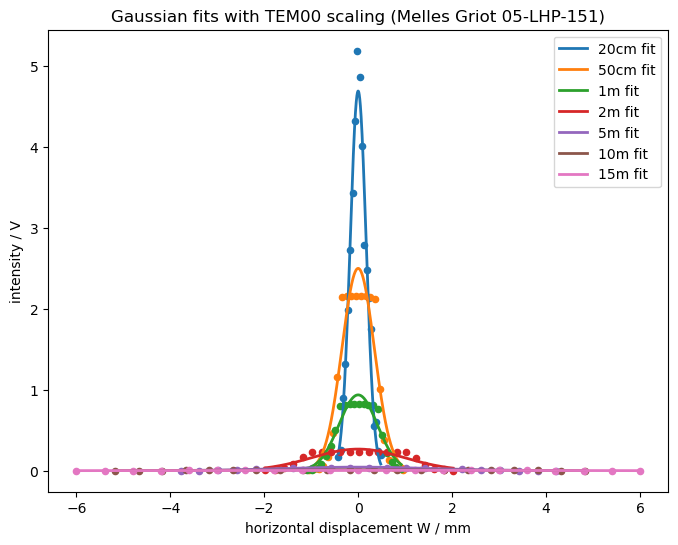

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

# TEM00 central intensity function (fixed for 05-LHP-151 laser)
def TEM00_I0(z, V_ref, z_ref):
    wavelength = 632.8e-9     # m
    w0 = 0.0003               # ~0.3 mm beam waist radius
    z_R = np.pi * w0**2 / wavelength

    w_ref = w0 * np.sqrt(1 + (z_ref / z_R)**2)
    w_z = w0 * np.sqrt(1 + (z / z_R)**2)

    return V_ref * (w_ref**2 / w_z**2)

# --- Load your CSV ---
df = pd.read_csv("PLLdata.csv")

# User-specified reference measurement
V_ref = 2.5    # volts measured at reference distance
z_ref = 0.5    # m reference distance

plt.figure(figsize=(8,6))

# Iterate groups in CSV order
for group in df["group"].unique():
    data = df[df["group"] == group]
    x_data = data["x"].values
    y_data = data["y"].values
    z_group = data["z"].iloc[0]  # distance for this group (all rows same z)

    # Gaussian fit
    p0 = [np.max(y_data), np.mean(x_data), np.std(x_data)]
    popt, _ = curve_fit(gaussian, x_data, y_data, p0=p0)
    A_fit, mu_fit, sigma_fit = popt

    # Shift x so peak at 0
    x_shifted = x_data - mu_fit

    # Expected TEM00 peak intensity at this z
    I0_expected = TEM00_I0(z_group, V_ref, z_ref)

    # Scale data + fit
    scale_factor = I0_expected / A_fit
    y_scaled = y_data * scale_factor

    x_fit = np.linspace(min(x_shifted), max(x_shifted), 500)
    y_fit = gaussian(x_fit, A_fit * scale_factor, 0, sigma_fit)

    # Plot
    plt.scatter(x_shifted, y_scaled, s=20)
    plt.plot(x_fit, y_fit, label=f"{group} fit", linewidth=2)

# Labels
plt.xlabel("horizontal displacement W / mm")
plt.ylabel("intensity / V")
plt.legend()
plt.title("Gaussian fits with TEM00 scaling (Melles Griot 05-LHP-151)")
plt.show()
